# Introduction

In my project i would like to analyze genomic sequences of prokariotes in looking for diffrent patterns of occuring codons which are vulnerable to mutation into stop codons.

There exists hypothesis that in genomic seqences there are regions in which is more codons which easy mutate into stop and there are regions were there is less of such codons. This can be correlated with efectivity of translation RNA into peptides. According to this hypothesis on the begining and on the end of the sequence should be regions with bigger participation of codons which mutate into stop. The resason for that is that when there is a nonsense mutation then cell would like to stop translation early to didn't use resources to translate wrong sequence, or to stop late and hope that the length of correctly translated sequence is enough to have correct protein.

# Data

### Source

Data which are used in this project were downloaded from NCBI database.

### Encoding

Probablity of each non-stop codon to mutate into stop codon is calculated using mutation matrix:

| |A|T|C|G|
|-|-|-|-|-|
|A|0.75|0.0625|0.0625|0.125|
|T|0.0625|0.75|0.125|0.0625|
|C|0.0625|0.125|0.75|0.0625|
|G|0.125|0.0625|0.0625|0.75|

For example ppb of mutating AAA codon into TAG codon is calculated as:
$$
P_{AAA \rightarrow TAG} = P_{A \to T} * P_{A \to A} * P_{A \to G} = 0.0625 * 0.75 * 0.125 = 0.005859375
$$

Because there is 3 stop codons, then ppb of mutating any codon (for example AAA) to stop codon is jointly probability of mutating into each of stop codons:
$$
P_{AAA \to STOP} = P_{AAA \to TAG} + P_{AAA \to TGA} + P_{AAA \to TAA}
$$

Now when we can calculate ppb of mutating any codon into stop we can encode genetic sequence as series where each codon is substituted by its ppb to mutate into stop. Such data are next smothed using running avarage. I decided to use window of size 50, additionaly all series are resapled to have length equal to 256.

# Methods

During work on this project following methods were used:
- DTW and SoftDTW (from tslearn library)
- DBA-Kmeans (from tslearn library)
- Kmeans, Spectral Clustering, Aglomerative Clustering (from sklearn library)
- Own implementation of function to calculate fitness between series and shapelet
- Genetic aglorithm to find shapelets
- Own neural net based on DTCR neural net (https://papers.nips.cc/paper/2019/hash/1359aa933b48b754a2f54adb688bfa77-Abstract.html)

Implementation to calculate fitness between series and shapelet is C++ code, which calculate euclidean distance between shapelet compared with each possible fragment of eries with the same length as shapelet, so if $f_s(t)$ is fitness between shapelet $s$ of length $k$ and series $t$ of length $n$, then:
$$
f_s(t)=min_{i \in \{0,...,n-k-1\}} \sum (t_{i..i+k}-s)^2
$$
Implemetation this is based on intristic functions (https://software.intel.com/sites/landingpage/IntrinsicsGuide/#) for speed efficiency and there is constrain that $k$ should be dividable by $8$.

Genetic algorithm is trying to find set of shapelets which maximise $silhouette\_indeks +1$. Such function is always non negative and has values from $0$ to $2$, where values smaller than $1$ mean, that there is no sensible clustering.

There are 3 mutation operators:
- shift operator - remove some number of probes ($x$) from one site of shapelet and make shapelet longer on the other site by $x$ probes which are taken from orginal series from which shapelet come from
- changing length of shapelet - add or remove 8 probes from one of sites of shapelet. If shapelet is making longer than additional probes are taken from orginal series
- add new shapelet - randomly choose new shapelet from series and add it to set

Recombination operator:

Take 2 sets of shapelets, for each shapelet randomly choose with ppb. $0,5$ if this shapelet should be in first or in second children.

DTCR is neural net which try to find meaningful representation of series in latent space. It consiste of two main part encoder and decoder. Encoder is LSTM (or GRU) Dilated Recurent Neural Net, so it is created by stacking some number of layers of LSTM cells. Each layer has different dilation parameter, which describe how big are "gaps" in information flow between cells. So if we have cell $c_i$ in layer with dilation equal $4$, then $c_i$ take as input output of cell $c_{i-4}$. Here there is used encoder with 4 layers with dilations $\{1,4,16,64\}$.
In orginal work decoder was simple one layer GRU, but here instead of that decoder is also Dilated RNN with 4 LSTM layers with the same dilations as encoder.
Additionaly output from encoder and input to decoder is processed by two layer, fully connected neural net.

In this project neural net was used only to get smoothed versions of sequences, which were next processed using normal methods. Source code of neural net can be found: https://gitlab.com/lekcyjna/dl-project/-/blob/master/src/DTCR%20with%20k-means%20normalization%20-%20resampled%20data%20-%20minimized%20-%20naprawioneKMeans.ipynb

Orange line are orginal series. Blue one are sequences smoothed using DTCR:

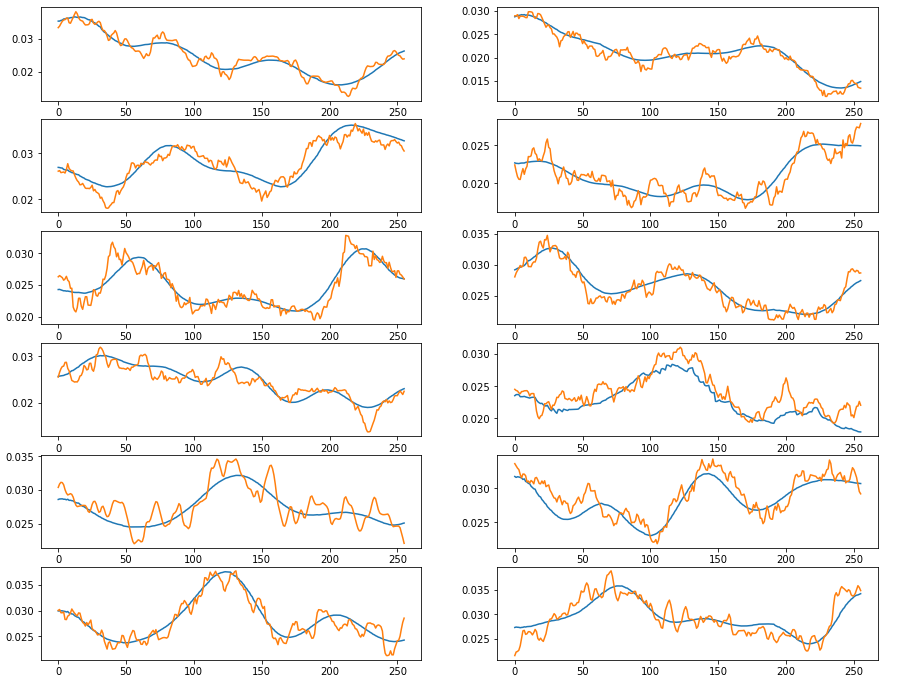

# Results

Results were obtained using Borrelia burgdorferi genome. First part of analyses was made using encoded sequences (as described in Data section), which were next resampled to 256 and after that there was calculated running averego with window 50 over such sequences, so resulting length was 206. Second part of analyses, are made on sequences smoothed by neural net. Because of architecture of this net sequences were first resampled to 306, and next there were preprocessed by taking running average with window 50, which result with sequences of length 256.

First step was to analyse different models and choose number of grups on which sequences should be clustered. Analyses was performed using DBA-Kmeans with SoftDTW, which got best results in pre-analyses (notebook "Clustering") for fixed number of clusters ($n\_clusters=6$). Clustering was made for number of clusters from 3 to 11 and based on the rule of thumb clustering into seven clusters was choosed (notebook "Selection of cluster number"). Using such number of clusters silhouette score was calculated for different models:

##### Analyses 1

Results of analyses using sequences smoothed using only running avarage. Length of sequences: $206$.

|Method|Silhouette score (softdtw)|
|-|-|
|Kmeans|**0.2221**|
|DBA-Kmeans with soft-DTW|0.2185|
|DBA-Kmeans with DTW|0.1643|
|Agglomerative clustering|0.1286|
|Spectral clustering|0.1252|
|Genetic shapelets + Kmeans| ~ -0.04|
|Genetic shapelets + Spectral Clustering| ~ -0.10|

##### Analyses 2

Results of analyses which used smoothing by running avarage and DTCR. Length of sequences: $256$

|Method|Silhouette score (softdtw)|Silhouette score (dtw)|
|-|-|-|
|DBA-Kmeans with soft-DTW|**0.2037**|0.0780|
|DBA-Kmeans with DTW|**0.2011**|**0.1504**|
|KMeans|**0.2006**|0.0761|
|Genetic shapelets + Kmeans|~ -0.04|-|

# Summary

Results are a bit disappointed. When we calculate silhouette score using normalized soft dtw as metric, then DBA-Kmeans which should be better on clustering series, has simmilar (after smoothing using DTCR) or worse (only running average) results than normal Kmeans. DBA-Kmeans is only significantly better than normal clustering methods when comparing using silhouette score based on DTW metric, but on the other hand in such case we have significantly worser slihouette score (0,15 instead of 0,20).

Possible reason why normal kmeans is so good can be fact that we have fixed length of series resampling it. So if there are some patterns which started in place which is constant to relative length of series, then after resampling all such patterns will start nearly in the some place.

Other reason for relative bad results in softdtw methods can be wrong choosed hyperparameter of softmin used in softdtw. During analyses there was used default parameter $\gamma = 1$, but this can be too small value as for values which can be achived by series. Our sequences have mean $\mu = 0.0254$ and standard deviation $\sigma = 0.005$. So when we want to calculate softmin for example for $x=0.02$ and $y=0.03$, then we have:
$$
\frac{0.02\exp(-0.02)+0.03\exp(-0.03)}{\exp(-0.02)+\exp(-0.03)}=0.0249
$$
So this "min" is nearly the same as mean between this two values. For comparasion, when we want to calculate softmin between $20$ and $30$ with the same hypreparameter then as result we got $20.0004$.

Overall worser results for dtw then for softdtw in tearms of silhouette score can be result of way in which distances between two sequences are calculated. Dtw centroids are have more pikes, so there is a possibility that dtw will optymalise aligment, by paring most of the points from sequence to one of pikes in centroid.

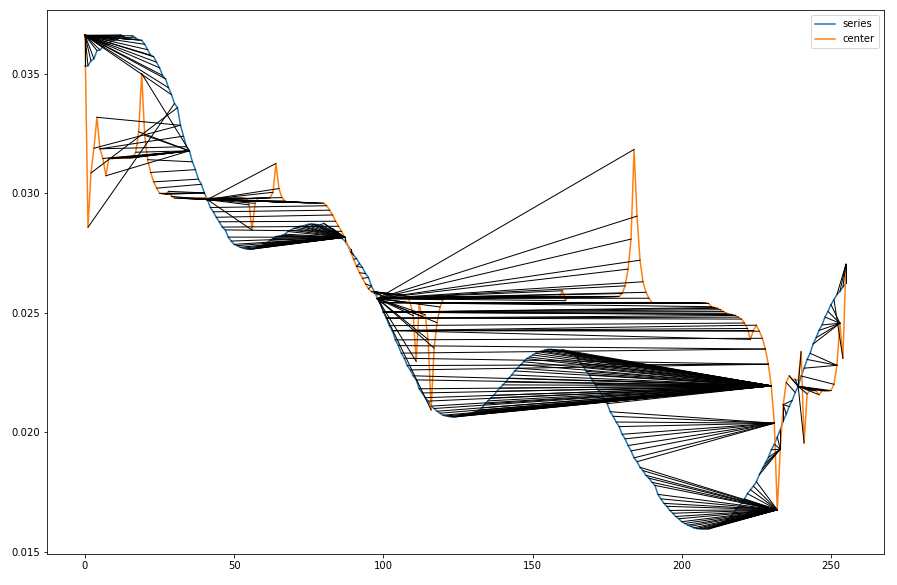

On this example plot we can see that circa half of points from sequence is paried with last 10-15 points from centoroid. On the other hand if we would have a sequence which on positions 100-250 has many values grater than 0.03, than probably they would be paired with pick on ca. 180 position and the resulting dtw score will be simmilar thought series would be totaly different.

On the other hand when we use softdtw we don't simply choose minimum, but we also analyse other candidates for minimum and we can give them some weight. So when we have picks in one of the sequences then we will got some penalty of wrong neighborhood, because in situation in which we move our pairing by on right or left, then we fall from such pick and our loss function will be hight.

# Possible futher improvements

- looking in the literature for indexes to measure quality of unsupervised grouping
- making analyses on sequences of non constant length (so without resampling)
- making analyse using softmax with different hyperparameter $\gamma$
- analysing using domain knowledge
- analysing influence of transition/transversion ratio on grouping